In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Dataset preprocess
class CaptchaDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.png')]
        
        # data augment
        self.transform = transforms.Compose([
            transforms.Resize((60, 240)),  # enlarge the initial size
            transforms.RandomCrop((50, 200)),  # random cut
            transforms.ColorJitter(contrast=0.3),  # color jitter
            transforms.RandomRotation(degrees=5, fill=255),  # random rotate with white fill 
            transforms.GaussianBlur(3, sigma=(0.1, 1.0)),  # random blur
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('L')
        return self.transform(image)

# generator
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.1),  # add dropout
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels)
        )
    
    def forward(self, x):
        return x + 0.3 * self.block(x)

class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.init_size = (4, 10)
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 256 * 4 * 10),
            nn.BatchNorm1d(256 * 4 * 10),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)  # add full-connected Dropout layer
        )
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # [B,128,8,20]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            ResidualBlock(128),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # [B,64,16,40]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            ResidualBlock(64),
            
            nn.Conv2d(64, 64*4, 3, padding=1),     # [B,256,16,40]
            nn.PixelShuffle(2),                    # [B,64,32,80]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 1, 3, padding=1),        # output layer
            nn.Upsample(size=(50, 200), mode='bilinear'),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 4, 10)
        return self.net(x)

#Discriminator
class SpectralDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # input: [B,1,50,200]
            nn.utils.spectral_norm(nn.Conv2d(1, 32, 4, 2, 1)),  # output: [32,25,100]
            nn.LeakyReLU(0.2),
            
            nn.utils.spectral_norm(nn.Conv2d(32, 64, 4, 2, 1)), # output: [64,12,50]
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, (0,1))),  # output: [128,5,25]
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.utils.spectral_norm(nn.Conv2d(128, 256, 3, 1, 1)),  # add a new layer
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Flatten(),
            nn.utils.spectral_norm(nn.Linear(256*5*25, 1))  # spectral normalization
        )

    def forward(self, x):
        return self.net(x)

# punishment
def gradient_penalty(D, real, fake, device):
    alpha = torch.rand(real.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = D(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True
    )[0]
    return ((gradients.norm(2, dim=(1,2,3)) - 1) ** 2).mean()
# record lists
d_losses = []
g_losses = []
gp_values = []
def train_gan():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    dataset = CaptchaDataset('samples')
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
    
    G = Generator(z_dim=100).to(device)
    D = SpectralDiscriminator().to(device)
    
    # optimizer
    optimizerG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.999))
    optimizerD = optim.Adam(D.parameters(), lr=5e-5, betas=(0.0, 0.999))
    
    # learning rate scheduler
    schedulerG = optim.lr_scheduler.StepLR(optimizerG, step_size=5, gamma=0.95)
    schedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size=5, gamma=0.95)
    
    # hyperargument
    n_epochs = 500 #100
    lambda_gp = 50

    global d_losses
    global g_losses
    global gp_values
    
    for epoch in range(n_epochs):
        for i, real_imgs in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            
            # traning
            D.train()
            G.train()
            
            optimizerD.zero_grad()
            
            # fake image
            z = torch.randn(batch_size, 100, device=device)
            fake_imgs = G(z)
            
            # calculate loss
            real_validity = D(real_imgs)
            fake_validity = D(fake_imgs.detach())
            gp = gradient_penalty(D, real_imgs.data, fake_imgs.data, device)
            
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
            d_loss.backward()
            
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(D.parameters(), 0.25)
            optimizerD.step()

            #record d losses and gp
            d_losses.append(d_loss.item())
            gp_values.append(gp.item())
            
            optimizerG.zero_grad()
            
            # regenerate fake image
            fake_imgs = G(z)
            gen_validity = D(fake_imgs)
            g_loss = -torch.mean(gen_validity)
            
            g_loss.backward()
            torch.nn.utils.clip_grad_norm_(G.parameters(), 0.25)
            optimizerG.step()

            # record g losses
            g_losses.append(g_loss.item())
            
            # monitor the traning process (by image)
            if i == len(dataloader)-1:
                print(f"[Epoch {epoch+1}/{n_epochs}] [Batch {i+1}/{len(dataloader)}] "
                      f"D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f} "
                      f"GP: {gp.item():.4f}")
        
        # update learning rate
        schedulerG.step()
        schedulerD.step()
        
        # checkpoints
        if (epoch+1) % 50 == 0:
            torch.save(G.state_dict(), f'checkpoints/G_epoch_{epoch+1}.pth')
            torch.save(D.state_dict(), f'checkpoints/D_epoch_{epoch+1}.pth')
            
            with torch.no_grad():
                G.eval()
                sample = G(torch.randn(5, 100, device=device))
                save_images(sample, f'checkpoints/samples_epoch_{epoch+1}.png')
                
def save_images(tensor, filename):
    tensor = (tensor.cpu().detach() + 1) / 2.0  # [-1,1] -> [0,1]
    
    if tensor.shape[1] == 1:
        tensor = tensor.repeat(1, 3, 1, 1)
    
    grid = torchvision.utils.make_grid(tensor, nrow=5)
    torchvision.utils.save_image(grid, filename)

if __name__ == "__main__":
    os.makedirs('checkpoints', exist_ok=True)
    train_gan()


D:\Tools\anaconda3\Lib\site-packages\torch\autograd\graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Epoch 1/500] [Batch 34/34] D_loss: 3.5197 G_loss: -1.9108 GP: 0.0843
[Epoch 2/500] [Batch 34/34] D_loss: -1.2405 G_loss: -3.8499 GP: 0.0095
[Epoch 3/500] [Batch 34/34] D_loss: -0.4359 G_loss: -7.3673 GP: 0.0192
[Epoch 4/500] [Batch 34/34] D_loss: -2.9901 G_loss: -7.0750 GP: 0.0089
[Epoch 5/500] [Batch 34/34] D_loss: -3.3996 G_loss: -7.5382 GP: 0.0097
[Epoch 6/500] [Batch 34/34] D_loss: -4.6804 G_loss: -9.5385 GP: 0.0050
[Epoch 7/500] [Batch 34/34] D_loss: -2.6970 G_loss: -5.8458 GP: 0.0050
[Epoch 8/500] [Batch 34/34] D_loss: -5.0879 G_loss: -6.1336 GP: 0.0027
[Epoch 9/500] [Batch 34/34] D_loss: -5.2744 G_loss: -10.0066 GP: 0.0082
[Epoch 10/500] [Batch 34/34] D_loss: -3.3980 G_loss: -10.0679 GP: 0.0025
[Epoch 11/500] [Batch 34/34] D_loss: -4.0694 G_loss: -11.7373 GP: 0.0071
[Epoch 12/500] [Batch 34/34] D_loss: -5.0353 G_loss: -9.4502 GP: 0.0044
[Epoch 13/500] [Batch 34/34] D_loss: -3.9974 G_loss: -10.0072 GP: 0.0020
[Epoch 14/500] [Batch 34/34] D_loss: -5.1106 G_loss: -9.9307 GP: 0.006

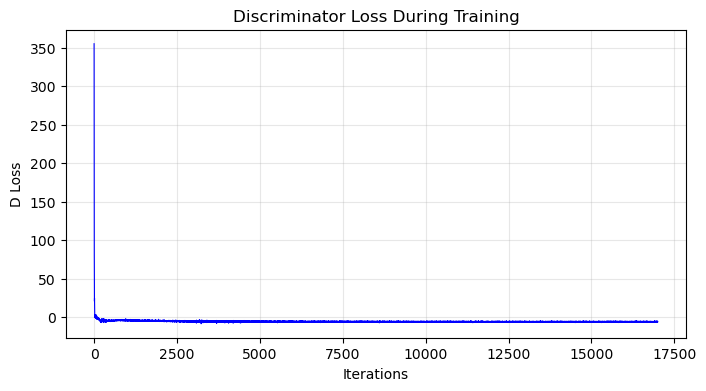

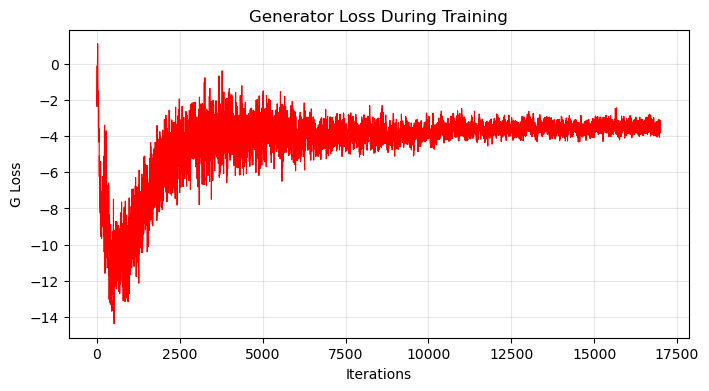

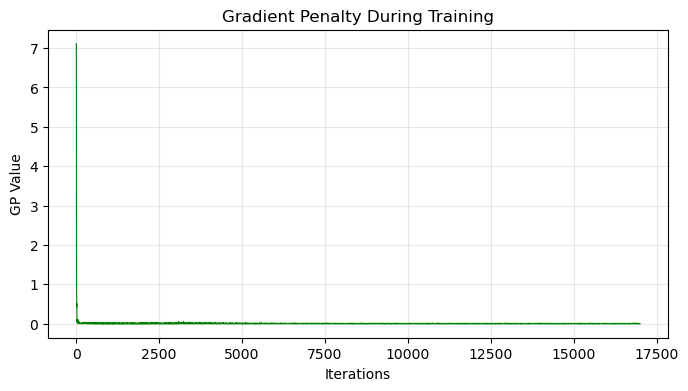

In [2]:
# D Loss
plt.figure(figsize=(8, 4))
plt.plot(d_losses, 'b', lw=0.8)
plt.title("Discriminator Loss During Training")
plt.xlabel("Iterations")
plt.ylabel("D Loss")
plt.grid(True, alpha=0.3)
plt.show()
# plt.savefig('d_loss.png', bbox_inches='tight')
plt.close()

# G Loss
plt.figure(figsize=(8, 4))
plt.plot(g_losses, 'r', lw=0.8)
plt.title("Generator Loss During Training")
plt.xlabel("Iterations")
plt.ylabel("G Loss") 
plt.grid(True, alpha=0.3)
plt.show()
# plt.savefig('g_loss.png', bbox_inches='tight')
plt.close()

# Gradient Penalty
plt.figure(figsize=(8, 4))
plt.plot(gp_values, 'g', lw=0.8)
plt.title("Gradient Penalty During Training")
plt.xlabel("Iterations")
plt.ylabel("GP Value")
plt.grid(True, alpha=0.3)
plt.show()
# plt.savefig('gradient_penalty.png', bbox_inches='tight')
plt.close()